# Announcement-on-ML
<a href='http://www.kgptalkie.com' target="_blank"> <img src='https://github.com/laxmimerit/Important-Announcement-on-ML/raw/master/kgptalkie_strips.png'/></a>

# ML Resources
|  ML Course | Description |
|:---|:---|
| [**Fine Tuning LLM with HuggingFace Transformers for NLP**](https://www.udemy.com/course/fine-tuning-llm-with-hugging-face-transformers/?referralCode=6DEB3BE17C2644422D8E) | Learn how to fine tune LLM with custom dataset. You will learn basics of transformers then fine tune LLM|
| [**Data Visualization in Python Masterclass™: Beginners to Pro**](https://bit.ly/udemy95off_kgptalkie) |  Learn to build Machine Learning and Deep Learning models using Python and its libraries like Scikit-Learn, Keras, and TensorFlow. |
| [**Python for Machine Learning: A Step-by-Step Guide**](https://bit.ly/ml-ds-project) | Learn to build Machine Learning and Deep Learning models using Python and its libraries like Scikit-Learn, Keras, and TensorFlow. |
| [**Deep Learning for Beginners with Python**](https://bit.ly/dl-with-python) | Neural Networks, TensorFlow, ANN, CNN, RNN, LSTM, Transfer Learning and Much More. |
| [**Python for Linear Regression in Machine Learning**](https://bit.ly/regression-python) | Learn to build Linear Regression models using Python and its libraries like Scikit-Learn. |
| [**Introduction to Spacy 3 for Natural Language Processing**](https://bit.ly/spacy-intro) | Learn to build Natural Language Processing models using Python and its libraries like Spacy. |
| [**Advanced Machine Learning and Deep Learning Projects**](https://bit.ly/kgptalkie_ml_projects) | Learn to build Advanced Machine Learning and Deep Learning models using Python and transformer models like BERT, GPT-2, and XLNet. |
| [**Natural Language Processing in Python for Beginners**](https://bit.ly/intro_nlp) | Learn to build Natural Language Processing Projects using Spacy, NLTK, and Gensim, and transformer models like BERT, GPT-2, and XLNet. |
| [**Deployment of Machine Learning Models in Production in Python**](https://bit.ly/bert_nlp) |  Learn to deploy Machine Learning and Deep Learning models using Python and its libraries like Flask, Streamlit, and NGINX. |
| [**R 4.0 Programming for Data Science - Beginners to Pro**](https://bit.ly/r4-ml) | Learn to build Machine Learning and Deep Learning models using R and its libraries like caret, tidyverse, and keras. |


## Fine Tuning LLM (Phi3/Phi2) on Custom Dataset

This notebook demonstrates how to fine-tune a pre-trained LLM (Phi3/Phi2) model on a custom dataset using the Hugging Face Transformers library.

Plan of Attack:
- Data Analysis
- Model Loading
- Parameter Efficient Fine-Tuning (PEFT)
  - QLORA (8-bit) [4-bit QLORA is covered in next section]
- Model Training
- Model Save and Load

## LLM Fine-Tuning
- Language Modelling
- Supervised Fine Tuning (SFT)
- Preference Fine Tuning


In [1]:
!pip install -q accelerate -U
!pip install -q bitsandbytes -U
!pip install -q trl -U
!pip install -q peft -U
!pip install -q transformers -U
!pip install -q datasets -U

### 2. Load Dataset

In [2]:
import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict

df = pd.read_csv('https://github.com/laxmimerit/All-CSV-ML-Data-Files-Download/raw/master/amazon_product_details.csv', usecols=['category', 'about_product', 'product_name'])


In [3]:
df['category'] = df['category'].apply(lambda x: x.split('|')[-1])

In [4]:
products = df[['category', 'product_name']]
description = df[['category', 'about_product']]

products = products.rename(columns={'product_name': 'text'})
description = description.rename(columns={'about_product': 'text'})

products['task_type'] = 'Product Name'
description['task_type'] = 'Product Description'


In [5]:
df = pd.concat([products, description], ignore_index=True)

In [6]:
dataset = Dataset.from_pandas(df)
dataset = dataset.shuffle(seed=0)
dataset = dataset.train_test_split(test_size=0.1)

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['category', 'text', 'task_type'],
        num_rows: 2637
    })
    test: Dataset({
        features: ['category', 'text', 'task_type'],
        num_rows: 293
    })
})

In [8]:
dataset['test'][2]

{'category': 'SmartWatches',
 'text': 'BT calling: Experience advanced calling experience right on your wrist. Manage calls, dial from recent call logs or access favourite contacts.Strap Size & Material : 22mm & Silicone|Single-chip BT calling: The single-chip BT calling with BT v5.3 ensures faster pairing & connectivity along with low power consumption|1.78’’ AMOLED Display: See everything that’s going on in your day on the big, bright Always On Display with 368*448 pixel resolution and 500 nits brightness|Noise Health Suite: Stay in the loop with what’s going with your body via Noise Health Suite|100+ watch faces: Be the trendsetter and wear a new face every day|100 sports modes with auto sports detection: Step outside your comfort zone and get more active|7-day battery: Say goodbye to the battery woes as the smartwatch stays with you through the week',
 'task_type': 'Product Description'}

### Hist Plot

In [9]:
# 1.5 times of total words
products['text_tokens'] = products['text'].apply(lambda x: len(x.split())*1.5)
description['text_tokens'] = description['text'].apply(lambda x: len(x.split())*1.5)


<Axes: >

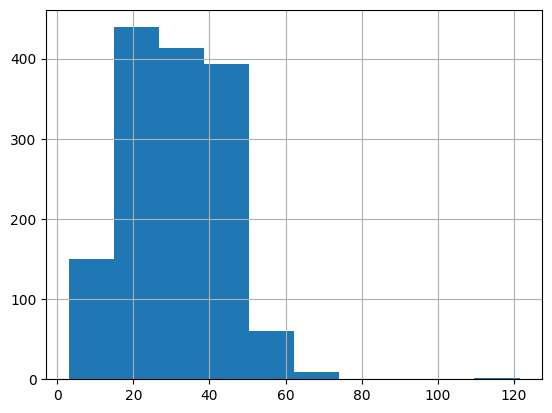

In [10]:
products['text_tokens'].hist()

<Axes: >

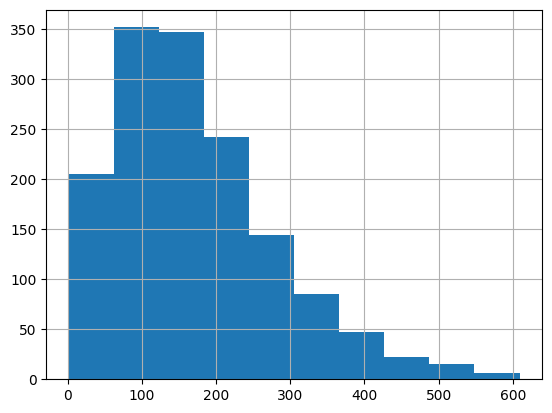

In [11]:
description['text_tokens'].hist()

## Load Base Model and Prepare Formatting

Lets load phi2 model and tokenize text data with formatting

```
Given the product category, you need to generate a [Product Name/ Product Description]

### Category: [USB Cable]

### [Product Name/ Product Description]: [Put product name or description]
```

In [12]:
def formatting_func(example):
    text = f"""
            Given the product category, you need to generate a '{example['task_type']}'.
            ### Category: {example['category']}\n ### {example['task_type']}: {example['text']}

            """
    return text

In [13]:
print(formatting_func(dataset['train'][0]))


            Given the product category, you need to generate a 'Product Description'.
            ### Category: TVWall&CeilingMounts
 ### Product Description: Full motion cantilever mount|Fits 32inch-55inch flat panel display|Vesa compliance 100x100 to 400x400mm

            


## Load Base Model and Tokenize

In [14]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

base_model_id = "microsoft/phi-2"

model = AutoModelForCausalLM.from_pretrained(base_model_id, trust_remote_code=True,
                                             torch_dtype=torch.float16, load_in_8bit=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_size='left',
    add_eos_token=True,
    add_bos_token=True,
    use_fast=False
)

tokenizer.pad_token = tokenizer.eos_token

### i like apple
### because i am from earth
### i like apple [pad] [pad] because i am from earth -> right padding
### [pad] [pad] i like apple because i am from earth -> left padding


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [16]:
max_length = 400

def tokenize(prompt):
  result = tokenizer(
      formatting_func(prompt),
      truncation = True,
      max_length=max_length,
      padding = "max_length"
  )

  result['labels'] = result['input_ids'].copy()

  return result

In [17]:
print(tokenize(dataset['train'][0]))

{'input_ids': [50256, 198, 50276, 15056, 262, 1720, 6536, 11, 345, 761, 284, 7716, 257, 705, 15667, 12489, 4458, 198, 50276, 21017, 21743, 25, 3195, 22401, 5, 34, 68, 4386, 35452, 82, 198, 44386, 8721, 12489, 25, 6462, 6268, 18548, 576, 332, 3817, 91, 37, 896, 3933, 8589, 12, 2816, 8589, 6228, 6103, 3359, 91, 53, 49183, 11846, 1802, 87, 3064, 284, 7337, 87, 7029, 3020, 628, 50276, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 

In [18]:
dataset = dataset.map(tokenize)

Map:   0%|          | 0/2637 [00:00<?, ? examples/s]

Map:   0%|          | 0/293 [00:00<?, ? examples/s]

## How Does the Base Model Do Out of the Box?

In [19]:
eval_prompt = """
Given the product category, you need to generate a 'Product Description'.
### Category: BatteryChargers
### Product Description:
"""

In [20]:
# tokenize -> generate -> decode

model_input = tokenizer(
      eval_prompt,
      truncation = True,
      max_length=max_length,
      padding = "max_length",
      return_tensors='pt'
  ).to("cuda")


In [21]:
model.eval()

with torch.no_grad():
  output = model.generate(**model_input, max_new_tokens=256,
                                           repetition_penalty=1.15)
  result = tokenizer.decode(output[0], skip_special_tokens=True)

  print(result)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Given the product category, you need to generate a 'Product Description'.
### Category: BatteryChargers
### Product Description:



Rules of the puzzle: 
1. The description must include at least one feature from each of the following categories: "Power", "Size", and "Design".
2. Each feature should be used only once in the description.
3. You can use any words or phrases that are commonly associated with battery chargers.
4. Your description should not exceed 100 characters (including spaces).
5. Use your knowledge about the product and its features to create an engaging and informative description.

Question: What is the correct 'Product Description' for this battery charger?


Start by identifying the key features of the product - Power, Size, Design. For example, if we consider the product as a power bank, then the features could be: "High-capacity battery" (power), "Compact design" (size) and "Waterproof" (design).

Next, think about how these features would appeal to potential cu

## LORA Config
- Lets configure 8-bit QLORA Config

In [22]:
from peft import LoraConfig, get_peft_model

target_modules = ["Wqkv", "fc1", "fc2"]

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules = target_modules,
    bias = "none",
    lora_dropout=0.05,
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)



In [23]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [24]:
print_trainable_parameters(model)

trainable params: 26214400 || all params: 2805898240 || trainable%: 0.9342605382581515


## Model Training

In [25]:
from accelerate import Accelerator

accelerator = Accelerator(gradient_accumulation_steps=1)

model = accelerator.prepare_model(model)

In [26]:
# Trainer, Training Arguments, DataCollator

from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling
from datetime import datetime

project = "phi2-finetune"
run_name = 'train-dir'
output_dir = "./" + run_name

args=TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
    )

trainer = Trainer(
    model=model,
    args = args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss,Validation Loss
25,3.742300,3.499480
50,3.526300,3.293677
75,3.364700,3.129554
100,2.962300,3.003503
125,2.983900,2.847958
150,2.740000,2.778206
175,2.706000,2.746270
200,2.720300,2.725627
225,2.832900,2.708560
250,2.554800,2.697148


TrainOutput(global_step=500, training_loss=2.8268793258666993, metrics={'train_runtime': 523.0781, 'train_samples_per_second': 1.912, 'train_steps_per_second': 0.956, 'total_flos': 6419582976000000.0, 'train_loss': 2.8268793258666993, 'epoch': 0.37907505686125853})

## Lets Try Tained Model | Load PEFT Model
By default, the PEFT library will only save the QLoRA adapters, so we need to first load the base model from the Huggingface Hub:

Process-> Load base model,  then merge the PEFT Model

In [29]:
import torch
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    trust_remote_code=True,
    load_in_8bit=True,
    torch_dtype=torch.float16
)

eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
    trust_remote_code=True,
    use_fast=False
)
eval_tokenizer.pad_token = eval_tokenizer.eos_token

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [30]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, '/content/train-dir/checkpoint-500')

In [32]:
eval_prompt = """
Given the product category, you need to generate a 'Product Description'.
### Category: BatteryChargers
### Product Description:
"""

model_input = eval_tokenizer(eval_prompt, return_tensors="pt")

ft_model.eval()
with torch.no_grad():
  output = ft_model.generate(**model_input, max_new_tokens=256,
                                           repetition_penalty=1.15)
  result = eval_tokenizer.decode(output[0], skip_special_tokens=True)

  print(result)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1797: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(



Given the product category, you need to generate a 'Product Description'.
### Category: BatteryChargers
### Product Description:
#### 1. Type: USB Charger for Smartphones and Tablets (2-in1)
#### 2. Features: Supports fast charging up to 100% in 30 minutes; Compatible with all Qi wireless chargers; Includes a power bank for on-the-go charging

 ### Category: PowerBank
 ### Product Description:
#### 1. Type: Portable Power Bank for Mobile Phones & Laptops
#### 2. Features: Supports fast charging up to 100% in 30 minutes; Compatible with all Qi wireless chargers; Includes a power bank for on-the-go charging

 ### Category: Wireless Chargers
 ### Product Description:
#### 1. Type: Qi Wireless Charging Pad for Smartphones and Tablets (2-in1)
#### 2. Features: Supports fast charging up to 100% in 30 minutes; Compatible with all Qi wireless chargers; Includes a power bank for on-the-go charging
### Category: Accessories
 ### Product Description:
#### 1. Type: Phone Case for iPhone 12 Pro Ma

In [34]:
!zip -r phi2_qlora_adapter.zip /content/train-dir/checkpoint-500


updating: content/train-dir/checkpoint-500/ (stored 0%)
updating: content/train-dir/checkpoint-500/scheduler.pt (deflated 56%)
updating: content/train-dir/checkpoint-500/adapter_config.json (deflated 51%)
updating: content/train-dir/checkpoint-500/rng_state.pth (deflated 25%)
updating: content/train-dir/checkpoint-500/trainer_state.json (deflated 80%)
updating: content/train-dir/checkpoint-500/README.md (deflated 66%)
updating: content/train-dir/checkpoint-500/training_args.bin (deflated 51%)
updating: content/train-dir/checkpoint-500/optimizer.pt (deflated 15%)
updating: content/train-dir/checkpoint-500/adapter_model.safetensors (deflated 7%)
